<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S10_HalfBaked_FixLRFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   DataLoaders.py  Gradcam.py    resNet.py
AlbTrainTransforms.py  displayData.py  LR_Finder.py  rohan_library.py
albumentations.py      execute.py      __pycache__


**Import required libraries**

In [3]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gc
# from Gradcam import GRADCAM, PLOT
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf

  pip install torch-lr-finder -v --global-option="amp"


REQUIRED LIBRARIES LOADED...


**Albumentations**

In [0]:
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensor
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [25]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders()
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [7]:
dataiter = iter(trainLoader)
# iter(trainLoader).next()

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


**Displaying Random Images**

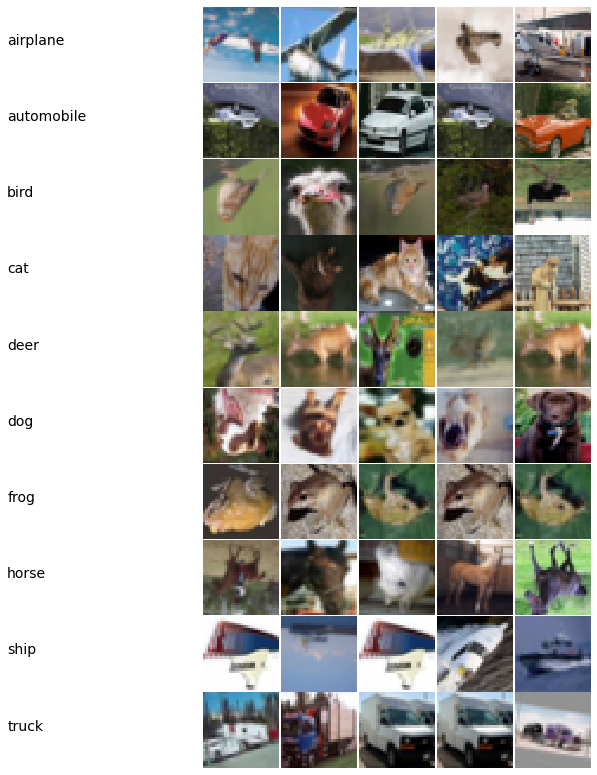

In [27]:
display.classImages(trainLoader)

**Model Summary**

In [9]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

**LR Finder**

**Installing Apex**

In [0]:
# pip install torch-lr-finder -v --global-option="amp"

In [0]:
torch.manual_seed(10)
criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-5, weight_decay=1e-4)
model = ResNet18().to(device)


**FastAI Approach**

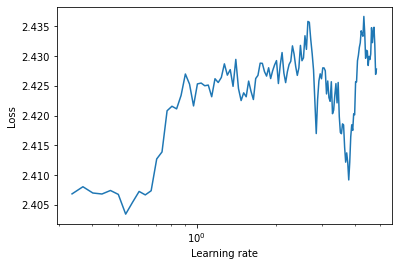

In [14]:

lr_finder = lrf.LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(trainLoader,  end_lr = 5, num_iter = 150)#, step_mode = 'exp')
lr_finder.plot()

In [15]:
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.bestLoss)]
Best_lr


1e-05

**Modelling**

In [17]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = ResNet18().to(device)


criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=1e-4, nesterov = True)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, steps_per_epoch=len(trainLoader), epochs = 25)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience=2, verbose=False)


model1 = execute.Test_Train(model, device, optimizer, criterion)
EPOCHS = 10
# print(criterion1)

for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  1


Loss=2.316051959991455 Batch_id=390 Accuracy=49.46: 100%|██████████| 391/391 [01:03<00:00,  6.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.0277).  Saving model ...

Test set: Average loss: 1.0277, Accuracy: 5370/10000 (53.70%)

EPOCH:  2


Loss=1.9641469717025757 Batch_id=390 Accuracy=65.31: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0607, Accuracy: 6144/10000 (61.44%)

EPOCH:  3


Loss=1.7701586484909058 Batch_id=390 Accuracy=71.63: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.0277 --> 0.9922).  Saving model ...

Test set: Average loss: 0.9922, Accuracy: 7230/10000 (72.30%)

EPOCH:  4


Loss=1.482534408569336 Batch_id=390 Accuracy=75.57: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.9922 --> 0.8010).  Saving model ...

Test set: Average loss: 0.8010, Accuracy: 7285/10000 (72.85%)

EPOCH:  5


Loss=1.3018825054168701 Batch_id=390 Accuracy=78.23: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8294, Accuracy: 7613/10000 (76.13%)

EPOCH:  6


Loss=1.651761531829834 Batch_id=390 Accuracy=80.50: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1902, Accuracy: 7613/10000 (76.13%)

EPOCH:  7


Loss=1.4639511108398438 Batch_id=390 Accuracy=82.09: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.8010 --> 0.2417).  Saving model ...

Test set: Average loss: 0.2417, Accuracy: 7733/10000 (77.33%)

EPOCH:  8


Loss=1.1790136098861694 Batch_id=390 Accuracy=83.20: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3278, Accuracy: 7874/10000 (78.74%)

EPOCH:  9


Loss=1.2193503379821777 Batch_id=390 Accuracy=84.32: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3155, Accuracy: 7975/10000 (79.75%)

EPOCH:  10


Loss=1.319261074066162 Batch_id=390 Accuracy=85.45: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]



Test set: Average loss: 0.7414, Accuracy: 7948/10000 (79.48%)



In [0]:
type(model1.test_losses)

**Plot Train & Test Curves**

Text(0.5, 1.0, 'Test Accuracy')

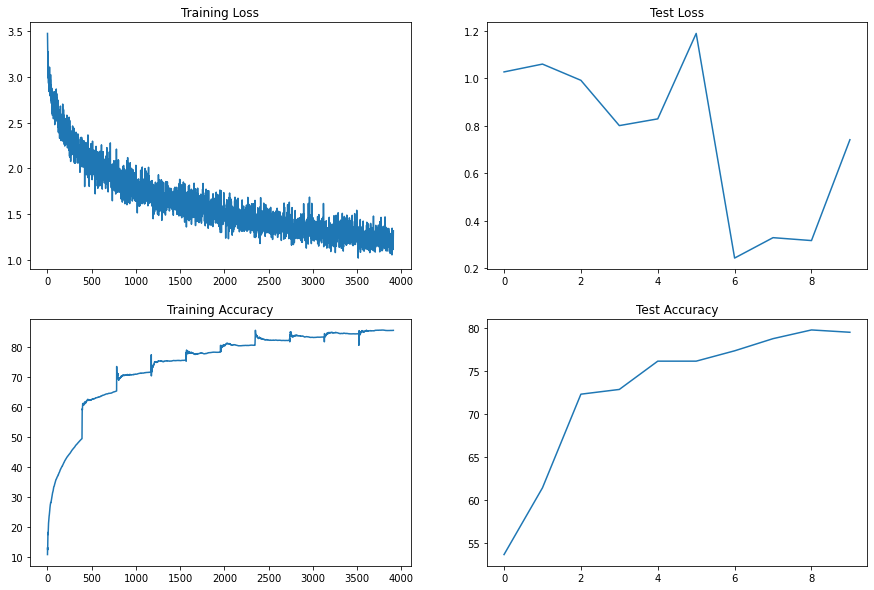

In [18]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(model1.train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(model1.train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(model1.test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(model1.test_acc)
axs[1, 1].set_title("Test Accuracy")

**Data for GradCam**

**GradCam Implementation**

In [20]:

images = [x['image'] for x in incorrectSamples[10:14]]
target_classes = [l['label'] for l in incorrectSamples[10:14]]
predicted_classes = [p['prediction'] for p in incorrectSamples[10:14]]
# print(images)
print('***target-classes***')
tc = [classes[t] for t in target_classes]
tc

print('***predicted-classes***')
pc = [classes[p] for p in predicted_classes]
pc
# for p in predicted_classes:
#   print(classes[p])
# print('predicted
# predicted_labels

***target-classes***
***predicted-classes***


['dog', 'plane', 'frog', 'car']

torch.Size([4, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


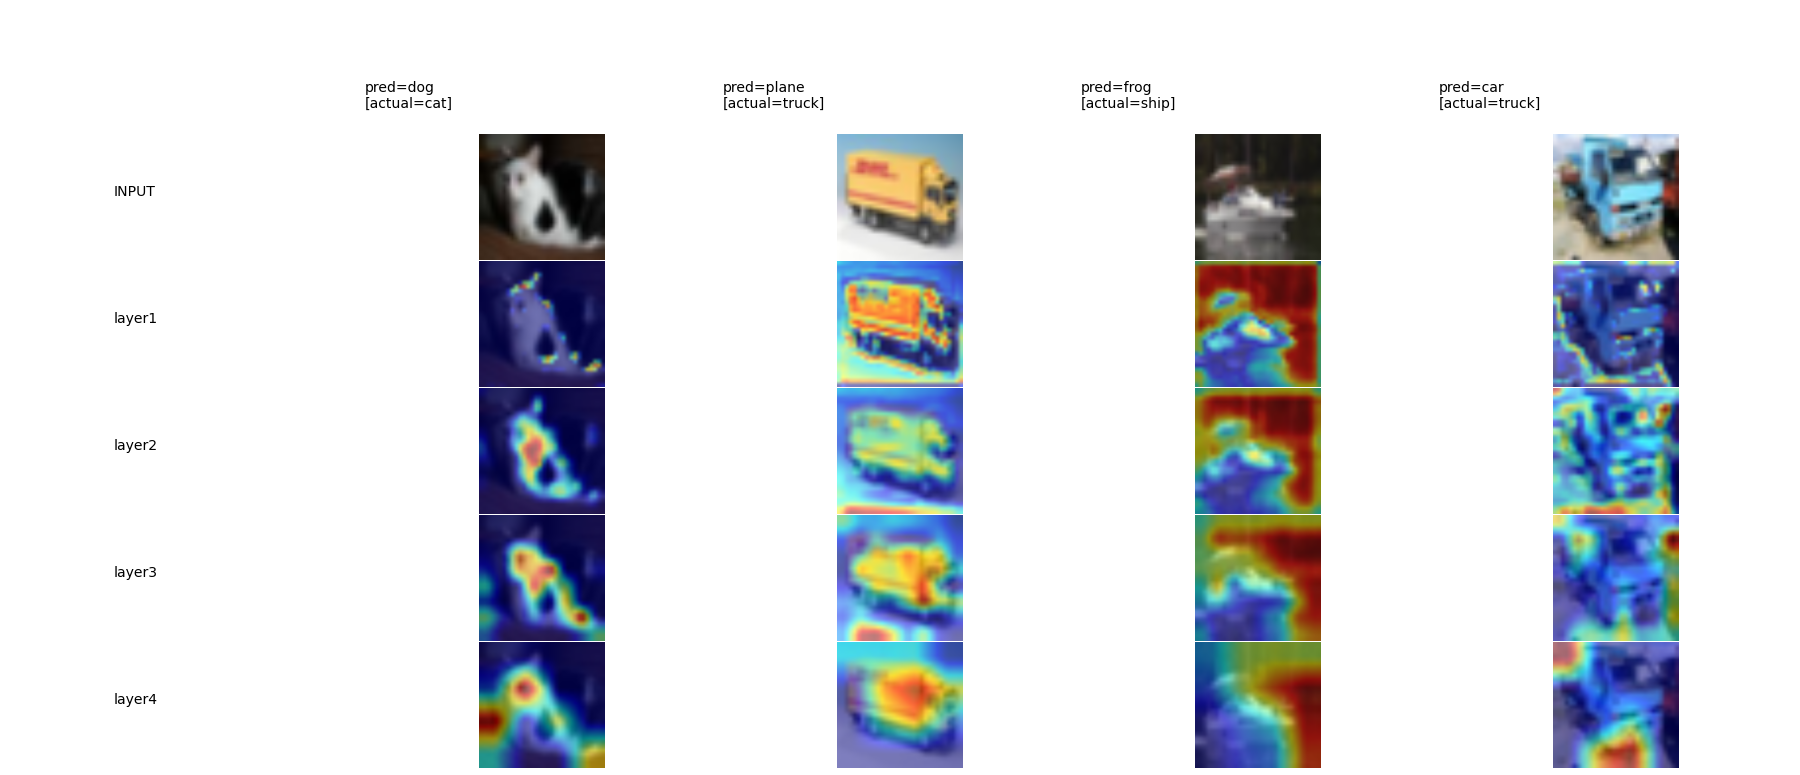

In [21]:

model = ResNet18().to(device)
image_size = (3,32,32)

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = gc.GRADCAM(images, device, target_classes, model, target_layers) # target_classes required only in GRADCAM func

gc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, tc, pc)


<Figure size 936x936 with 0 Axes>

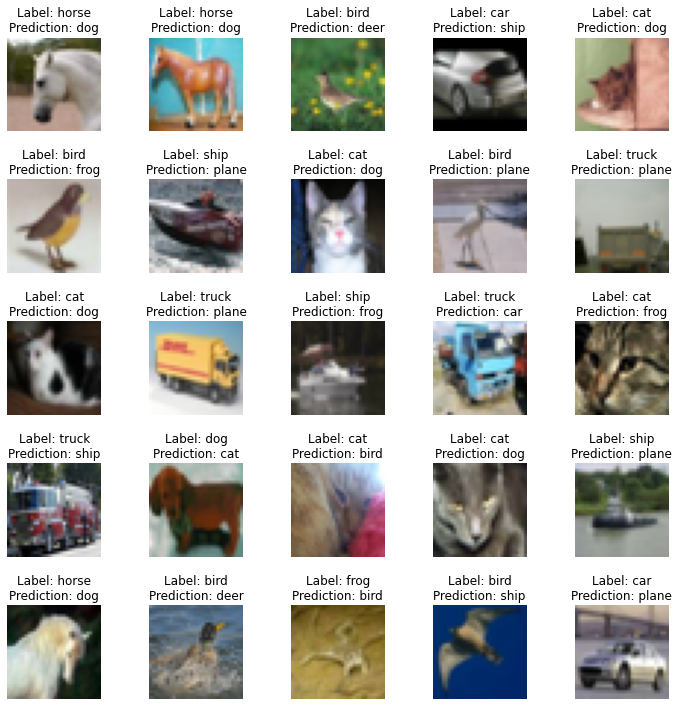

In [22]:
display.misclassifiedOnes(model, testLoader, incorrectSamples,'Misclassfied.png')